In [493]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Section A: Molecular Dynamics Using Simulations

### Question 1
Check that equiprobability is satisfied in **direct_disks_box.py**. Check it not for all legal configurations, but for the three configurations (a, b, c) shown below. The probability to hit any of these configurations exactly is of course zero, so we must put little boxes around them, as shown in red:

<img src="Section 1.png"/>

Using small boxes $[x - \delta_{xy}, x + \delta_{xy}]$, etc, modify the program **direct_disks_box_multirun.py** to show that the probability to sample configurations a, b, and c are the same (within the numerical precision), with

In [360]:
a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))

### Solution

In [3]:
def draw_circle(coord, radius):
    fig, ax = plt.subplots()
    for x in coord:
        c = plt.Circle(x, radius) 
        ax.add_artist(c)
    
    plt.show()

In [122]:
def sample_disks(balls, radius):
    coords = np.random.uniform(low = radius, high = 1-radius, size=(balls, 2))
    
    for i in range(coords.shape[0]):
        for j in range(i, coords.shape[0]):
            if np.sum((coords[0] - coords[1])**2) < 2*radius:
                return sample_disks(balls, radius)
    return coords

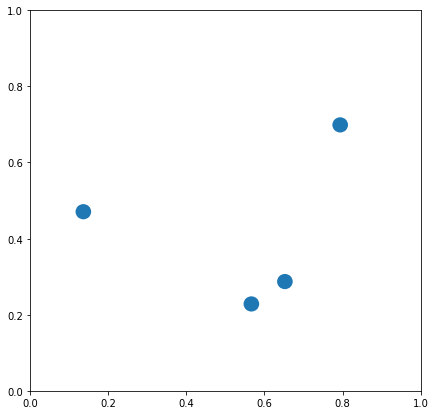

In [5]:
plt.rcParams['figure.figsize'] = [7, 7]

draw_circle(sample_disks(4, 0.02), 0.02)

In [6]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

hits = {"conf_A":0, "conf_B":0, "conf_C":0}

del_xy = 0.05
balls = 4
radius = 0.15
runs = int(1e6)

In [7]:
# Sampling of to compare results.

for x in range(1, runs+1):
    sample_points = sample_disks(balls, radius)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < del_xy)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < del_xy)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < del_xy)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000000 samples: {'conf_A': 0, 'conf_B': 1, 'conf_C': 1}


In [8]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

hits = {"conf_A":0, "conf_B":0, "conf_C":0}

del_xy = 0.10
balls = 4
radius = 0.15
runs = int(1e6)

In [9]:
for x in range(1, runs+1):
    sample_points = sample_disks(balls, radius)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < del_xy)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < del_xy)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < del_xy)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 5, 'conf_C': 3}
For 1000000 samples: {'conf_A': 15, 'conf_B': 58, 'conf_C': 62}


Here all the points are configuration ie. each 8-dimensional points are sampled independently. But due to that sometime, such configurations are sampled which violates the overlapping constraints, but those configurations are rejected and the point is resampled until it doesn't violate the constraints.
If the sampling was done as a chain, only the sampling os seed would be independent and the rest of the points will be conditioned on that first point and the probability of the sample will not be equiprobable each participant of the set of all possible configuration.

### Question 2

Analogously, check equiprobability of the configurations a, b, and c of Section A1, for the algorithm markov_disks_box.py

Compare with the analogous problem in Section A1: You might observe larger fluctuations of the results. Is that at all possible, given that Markov-chain sampling and Direct sampling should yield the same results?

### Solution

In [51]:
def sample_disks_markov(balls, radius, delta):
    points = [np.random.uniform(low=radius, high=1-radius, size=(1,2))]
    
    while len(points)<balls:
        n_point = points[-1] + np.random.uniform(low=-delta, high=delta, size=(1,2))
        if np.min(n_point) >= radius and np.max(n_point) <= 1-radius:
            points.append(n_point)
    
    points = np.squeeze(np.array(points))

    for i in range(points.shape[0]):
        for j in range(i, points.shape[0]):
            if np.sum((points[0] - points[1])**2) < 2*radius:
                return sample_disks_markov(balls, radius, delta)
    return points

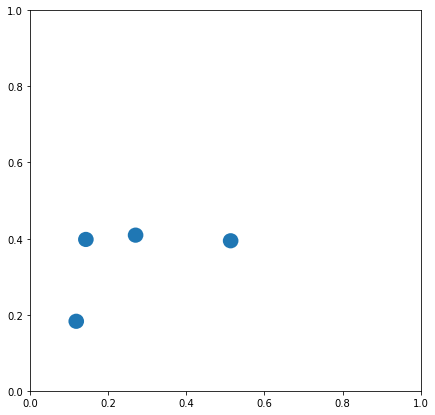

In [58]:
plt.rcParams['figure.figsize'] = [7, 7]

draw_circle(sample_disks_markov(4, 0.02, 0.4), 0.02)

In [85]:
conf_a = np.array(a)
conf_b = np.array(b)
conf_c = np.array(c)

configurations = {"conf_A": conf_a, "conf_B": conf_b, "conf_C": conf_c}
hits = {"conf_A":0, "conf_B":0, "conf_C":0}

del_xy = 0.12
balls = 4
radius = 0.10
delta = 0.5
runs = int(1e6)

In [86]:
# Sampling to compare results.

for x in range(1, runs+1):
    sample_points = sample_disks_markov(balls, radius, delta)

    hits["conf_A"] += (np.max(np.abs(sample_points - conf_a)) < del_xy)
    hits["conf_B"] += (np.max(np.abs(sample_points - conf_b)) < del_xy)
    hits["conf_C"] += (np.max(np.abs(sample_points - conf_c)) < del_xy)
    
    if x in [int(1e1), int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]:
        print("For {} samples: {}".format(x, hits))

For 10 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 1000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 10000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 0}
For 100000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 1}
For 1000000 samples: {'conf_A': 0, 'conf_B': 0, 'conf_C': 22}


Markov-chain sampling and Direct sampling could yield the same results but for very large numbers of runs because in Markov Chain sampling many samples are rejected and that can be compensated by collecting a large number of samples.

Markov chain sampling can result in equiprobability states only if the jump size if space from which has to be sampled is a subset of the set of points which can be sampled at any time instant t in the Markov Chain sampling which is possible only if the jump size is large enough that it over the whole space from which sampling has to be done.

In case of relatively small jump size, as compared to the dimension of the space, all the points of space may not equally probable.

### Question 3

Consider the program event_disks_box.py.

Prove, without any numerical simulations, that no event-configuration will count for the configurations a, b, c of Section A1. Show that this means that the event positions are not equally probable (Note that this is rather natural).

Modify the program event_disks_box.py, so that it determines the configurations at constant time intervals, t=0, Delta t, 2 Delta t, 3 Delta t,.. It is for these configurations that equal probability should be valid.

Note that in this program, we use del_xy = 0.1, and sigma = 0.1, in order to improve statistics.

Then do the following:

+ First answer the question about event-configurations from the beginning of the section.
+ Run the program for 5,000,000 events, write down how many times you were close to a, b, and c. (choose smaller number of events, if you cannot run that long). Do you get an indication in favor of equiprobability?
+ What is the total running time at the end of the simulation, and at what times are the configurations analyzed (is it at time 0,1,2,3,... or at times 0,2,4,6,... or at times 0, 0.1, 0.2, 0.3....?). (Hint: put print statements to find out).

### Solution

In [446]:
def wall_time(pos_a, vel_a, radius):
    if vel_a > 0.0:
        del_t = (1.0 - radius - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - radius) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, radius):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * (del_x_sq - 4.0 * radius ** 2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

def min_arg(l):
    return min(zip(l, range(len(l))))

def compute_next_event(pos, vel):
    wall_times = [wall_time(pos[k][l], vel[k][l], radius) for k, l in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], radius) for k, l in pairs]
    return min_arg(wall_times + pair_times)

def compute_new_velocities(pos, vel, next_event_arg):
    if next_event_arg < len(singles):
        collision_disk, direction = singles[next_event_arg]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[next_event_arg - len(singles)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal


In [500]:
def MD_samples(events = 100, balls=4, radius=0.05, dt = 0.02):

    samples = []
    
    pos = sample_disks(balls, radius)
    vel = np.random.uniform(low=radius, high=1-radius, size=(balls, 2))
    singles = sum([[(x, 0), (x, 1)] for x in range(balls)], [])
    pairs = list(combinations(range(0, balls),2))
    t = 0.0
    next_event, next_event_arg = compute_next_event(pos, vel)

    samples.append(np.copy(pos))

    for step in range(events):
        if dt:
            next_t = t + dt
        else:
            next_t = t + next_event
        while t + next_event <= next_t:
            t += next_event
            for k, l in singles: pos[k][l] += vel[k][l] * next_event
            compute_new_velocities(pos, vel, next_event_arg)
            next_event, next_event_arg = compute_next_event(pos, vel)
        remain_t = next_t - t
        for k, l in singles: pos[k][l] += vel[k][l] * remain_t

        samples.append(np.copy(pos))

        t += remain_t
        next_event -= remain_t
        
    return samples, t

In [501]:
samples, _ = MD_samples(100, balls=6)

**1.** Not Answered yet.

**2.** I was close to A, B and C 706, 680 &  663 times respectively. According to this simulation as well as other simulations that I've tried, it seems that A, B, and C are equiprobable.

**3.** Total Running Time: 611851.1288527708 units

# Section B: Molecular Dynamics Using Visualiations

### Direct Sampling Histograms

In [503]:
balls = 4
radius = 0.1197
n_runs = int(1e6)
delta = 0.4

In [121]:
hist_data = [sample_disks(balls, radius) for x in range(n_runs)]
hist_data  = np.vstack(hist_data)

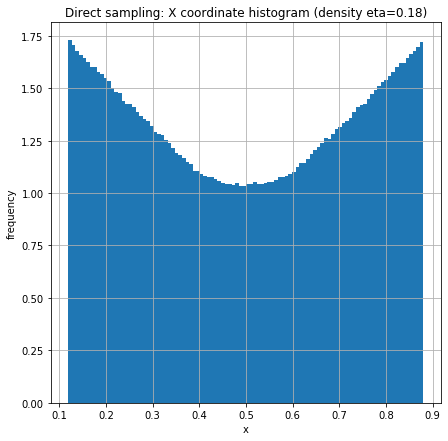

In [140]:
plt.hist(hist_data[:,0], bins=100, density=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Direct sampling: X coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

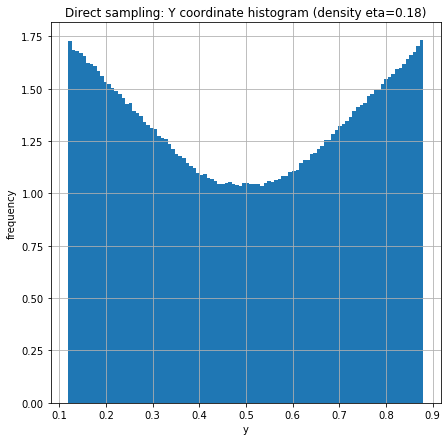

In [511]:
plt.hist(hist_data[:,1], bins=100, density=True)
plt.xlabel('y')
plt.ylabel('frequency')
plt.title('Direct sampling: Y coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

### Markov Chain Sampling Histograms

In [504]:
balls = 4
radius = 0.1197
n_runs = int(1e4)
delta = 0.4

In [148]:
hist_data_markov = [sample_disks_markov(balls, radius, delta) for x in range(n_runs)]
hist_data_markov  = np.vstack(hist_data_markov)

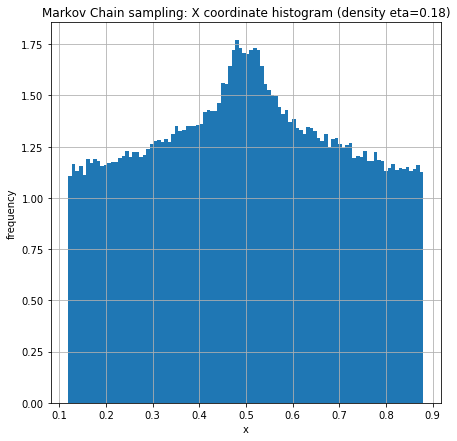

In [149]:
plt.hist(hist_data_markov[:,0], bins=100, density=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Markov Chain sampling: X coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

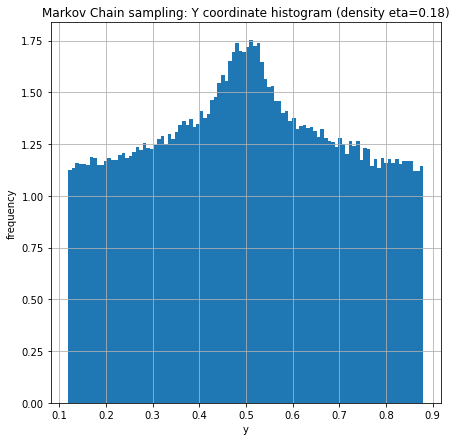

In [510]:
plt.hist(hist_data_markov[:,1], bins=100, density=True)
plt.xlabel('y')
plt.ylabel('frequency')
plt.title('Markov Chain sampling: Y coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

### Sampling using Dynamics of the System

In [508]:
balls = 4
radius = 0.1197
n_runs = int(1e6)
dt = 0.2

In [509]:
hist_data_md = MD_samples(n_runs, balls, radius, dt)
hist_data_md = np.vstack(hist_data_markov)

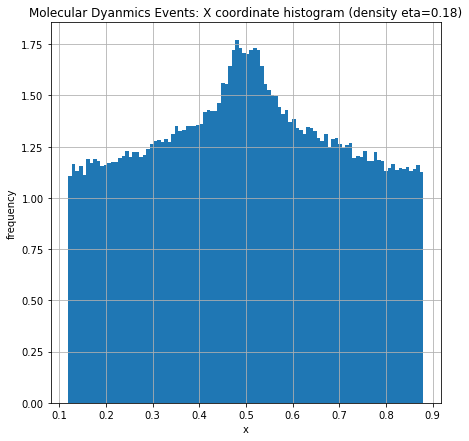

In [513]:
plt.hist(hist_data_md[:,0], bins=100, density=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Molecular Dyanmics Events: X coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

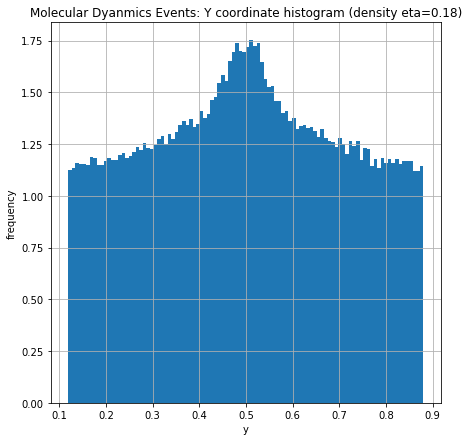

In [514]:
plt.hist(hist_data_md[:,1], bins=100, density=True)
plt.xlabel('y')
plt.ylabel('frequency')
plt.title('Molecular Dyanmics Events: Y coordinate histogram (density eta=0.18)')
plt.grid()
plt.show()

### Question 1

Briefly explain (in two sentences) the paradox that gives a non-constant histogram for a manifestly equiprobable probability distribution, as we checked in section A1.

### Solution

### Question 2

Comment on your findings by Histograms: Do you find that direct-sampling, Markov-chain sampling and molecular dynamics give the same histogram for the x-position of the disks?

### Solution